# Snooker Master
- __CS-GY_6643 Computer Vision__  Final Project
- Group:
    - Rui Wang (rw3068) 
    - Lingfeng Fan (lf2606)
    - Runze Li (rl5083)
 

### importing libraries

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [24]:
width, height = 280, 560  # size of output image

### Function 1. Creating snooker 2D table image
- input: None; output: image
- designing the table: every snooker table has a line and half a circle in one of its sides
    - the line is (height / 5)
    - the circle is in the middle of the line with radius (width / 3)

In [25]:
def create_table():
    
    # new generated img 
    img = np.zeros((height, width, 3), dtype = np.uint8) # create 2D table image 
    img[:, :] = [0, 180, 10] # setting RGB colors to green pool table color; (0,180,10) = certain green
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    
    # create circle in the right size
    cv2.circle(img, (int(width / 2), int(height / 5)), # center of circle
               int((width / 3) / 2), # radius
               (50, 255, 50)) # color
    
    # delete half of circle by coloring in green color
    img[int(height / 5):height, 0:width] = [0, 180, 10]
    
    # create line
    cv2.line(img, (0, int(height / 5)), (width,int(height / 5)), (50, 255, 50)) 
    
    return img


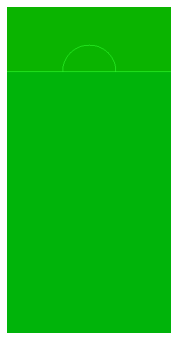

In [26]:
test_table = create_table()

plt.figure(figsize=(12, 6))
plt.imshow(test_table)
plt.axis('off')
plt.show()

### Function 2: Drawing borders & holes on snooker table
- input: image, 2D generated table
- output: image, 2D generated table + borders + holes

In [27]:
def draw_holes(input_img, color3 = (200, 140, 0)):
        
    color = (190, 190, 190)  # gray color
    color2 = (120, 120, 120) # gray color, for circles (holes) on generated img

    img = input_img.copy()   # make a copy of input image
    
    # borders 
    cv2.line(img, (0, 0),(width, 0), color3, 3)           # top
    cv2.line(img, (0, height),(width, height), color3, 3) # bot
    cv2.line(img, (0, 0), (0, height), color3, 3)         # left
    cv2.line(img, (width, 0), (width, height), color3, 3) # right
    
    # adding circles to represent holes on table
    cv2.circle(img, (0, 0), 11, color, -1)          # top right
    cv2.circle(img, (width, 0), 11, color, -1)      # top left
    cv2.circle(img, (0, height), 11, color, -1)     # bot left
    cv2.circle(img, (width, height), 11, color, -1) # bot right
    cv2.circle(img, (width, int(height / 2)), 8, color, -1) # mid right
    cv2.circle(img, (0,int(height / 2)), 8, color, -1)     # mid left
    
    # adding another, smaller circles to the previous ones
    cv2.circle(img, (0, 0), 9, color2, -1)          # top right
    cv2.circle(img, (width, 0), 9, color2, -1)      # top left
    cv2.circle(img, (0, height), 9, color2, -1)     # bot left
    cv2.circle(img, (width, height), 9, color2, -1) # bot right
    cv2.circle(img, (width, int(height / 2)), 6, color2, -1) # mid right
    cv2.circle(img, (0, int(height / 2)), 6, color2, -1)     # mid left
    
    return img

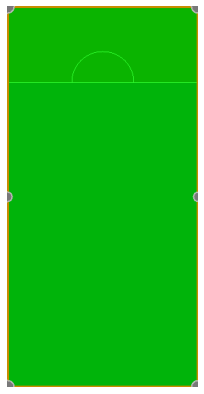

In [28]:
test_table_holes = draw_holes(test_table)

plt.figure(figsize=(14, 7))
plt.imshow(test_table_holes)
plt.axis('off')
plt.show()

### Function 3: Drawing balls on snooker table
- input: - ctrs: contours; - background: image to draw on (new 2D table by default); - radius: radius of the drawn balls; - size: size of line (-1 by default to fill); - img: image which the contours are taken from
- output: image, with drawn snooker balls
- first, using moments, calculates (x,y) of each contour center; next, masks each contour (ball) and calculates its average inner color; finely, draws circles that look like a snooker ball for each contour (one circle for inner color of ball, one for a black border of ball and one for small light reflection).

In [29]:
def draw_balls(ctrs, background = create_table(), radius = 7, size = -1, img = 0):

    K = np.ones((3, 3), np.uint8) # filter; 3x3 matrix, serves as a kernel for erosion operation
    
    final = background.copy()    # canvas
    mask = np.zeros((560, 280), np.uint8) # empty black image, same size as 2d generated final output; isolate regions of interest
    
    
    for x in range(len(ctrs)):   # for all contours
        
        # find center of contour
        M = cv2.moments(ctrs[x])
        cX = int(M['m10'] / M['m00']) # X pos of contour center
        cY = int(M['m01'] / M['m00']) # Y pos
        
        # find color average inside contour
        mask[...] = 0 # reset the mask for every ball 
        cv2.drawContours(mask, ctrs, x, 255, -1) # draws mask for each contour
        mask =  cv2.erode(mask,K,iterations = 3) # erode mask several times to filter green color around balls contours
        
        
        # balls design:
        
        
        # circle to represent snooker ball
        final = cv2.circle(final,    # img to draw on
                           (cX, cY), # position on img
                           radius,   # radius of circle - size of drawn snooker ball
                           cv2.mean(img, mask), # color mean of each contour-color of each ball (src_img=transformed img)
                           size)     # -1 to fill ball with color
        
        # add black color around the drawn ball (for cosmetics)
        final = cv2.circle(final, (cX,cY), radius, 0, 1) 
        
        # small circle for light reflection
        final = cv2.circle(final, (cX - 2, cY - 2), 2, (255, 255, 255), -1)
                 
    return final

### Function 4: Getting contours & Filtering
- gets contours and filters them by size and shape, then returns filtered contours
    - input: - ctrs: contours; - min_s: min area size of accepted contour; - max_s: max area size of accepted contour; - alpha: parameter to find wanted shape
    - output: contours
- if a contour is in the right size, min < area < max and in the right shape (check with alpha), it means the contour is most likely a ball
- alpha: a parameter that helps to filter objects by their shapes

In [30]:
def filter_ctrs(ctrs, min_s = 90, max_s = 358, alpha = 3.445):  
    
    filtered_ctrs = [] # list for filtered contours
    
    for x in range(len(ctrs)): # for all contours
        
        rot_rect = cv2.minAreaRect(ctrs[x]) # area of rectangle around contour
        w = rot_rect[1][0]              # width of rectangle
        h = rot_rect[1][1]              # height
        area = cv2.contourArea(ctrs[x]) # contour area 

        if (h * alpha < w) or (w * alpha < h): # if the contour isnt the size of a snooker ball
            continue
            
        if (area < min_s) or (area > max_s):   # if the contour area is too big/small
            continue

        # if failed previous statements then it is most likely a ball
        
        filtered_ctrs.append(ctrs[x]) # add contour to filtered cntrs list

    return filtered_ctrs

### Function 5: Finding the balls & Returning top view
- input: src: image, frame from snooker video
- output: image: 2D top view
- warps perspective of the input image, blurs, finds table's mask, filters the mask (closing), invert mask, finds and filters contours, draws balls on canvas image and returns the canvas image

In [31]:
def find_balls(src):
    final = create_table()
    
    # warp perspective
    matrix = cv2.getPerspectiveTransform(pts1, pts2) # getting perspective by 4 points of each image
    transformed = cv2.warpPerspective(src, matrix, (width, height)) # warps perpective to new image

    # apply blur
    transformed_blur = cv2.GaussianBlur(transformed,(5, 5), cv2.BORDER_DEFAULT)
    blur_RGB = cv2.cvtColor(transformed_blur, cv2.COLOR_BGR2RGB) # rgb version

    # mask
    hsv = cv2.cvtColor(blur_RGB, cv2.COLOR_RGB2HSV) # convert to hsv
    mask = cv2.inRange(hsv, lower, upper) # table's mask

    # filter mask
    kernel = np.ones((5, 5), np.uint8)
    mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # dilate -> erode
    
    # apply threshold
    ret, mask_inv = cv2.threshold(mask_closing, 5, 255, cv2.THRESH_BINARY_INV)
       
    # create image with masked objects on table 
    masked_objects = cv2.bitwise_and(transformed, transformed, mask = mask_inv)

    # find contours and filter them
    ctrs, hierarchy = cv2.findContours(mask_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ctrs = filter_ctrs(ctrs) # filter contours by sizes and shapes

    # draw table + balls
    final = draw_balls(ctrs, radius = 8, img = transformed)
    final = draw_holes(final)
    
    return final

### Function 6: find_ctrs_color(ctrs, input_img)
- gets image (of snooker table), applies several methods to detect the balls and returns 2D top view with drawn, colored balls
    - input: ctrs: contours input_img: image that the contours are taken from
    - output: image, black image with large colored circle for each contour
- masks each contour; erodes the mask to clear some of the green color around contour; draws contour with its calculated inner color; returns an image of the colored contours with a black background

In [32]:
def find_ctrs_color(ctrs, input_img):

    K = np.ones((3,3), np.uint8)
    output = input_img.copy()
    gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)  # gray version
    mask = np.zeros(gray.shape, np.uint8)               # empty mask

    for i in range(len(ctrs)):
        
        # find center of contour
        M = cv2.moments(ctrs[i])
        cX = int(M['m10'] / M['m00']) # X pos of contour center
        cY = int(M['m01'] / M['m00']) # Y pos
    
        mask[...] = 0 # reset the mask for every ball 
    
        cv2.drawContours(mask, ctrs, i, 255, -1)   # draws the mask of current contour (every ball is getting masked each iteration)

        mask =  cv2.erode(mask, K, iterations = 3) # erode mask to filter green color around the balls contours
        
        output = cv2.circle(output, # img to draw on
                         (cX, cY),  # position on img
                         20,        # radius of circle - size of drawn snooker ball
                         cv2.mean(input_img, mask), # color mean of each contour-color of each ball (src_img=transformed img)
                         -1)        # -1 to fill ball with color
    
    return output

### Function 7: draw_rectangles(ctrs, img)
- gets image (of snooker table), draws a rectangle around each contour
    - input: ctrs: contours input_img: image that the contours are taken from
    - output: image, same as input image but with rectangles on contours
- finds width and height of each contour by using moments; draws a rectangle around each contour on a canvas image; returns the canvas image



In [33]:
def draw_rectangles(ctrs, img):
    
    output = img.copy()
    
    for i in range(len(ctrs)):
    
        M = cv2.moments(ctrs[i]) # moments
        rot_rect = cv2.minAreaRect(ctrs[i])
        w = rot_rect[1][0] # width
        h = rot_rect[1][1] # height
        
        box = np.int64(cv2.boxPoints(rot_rect))
        cv2.drawContours(output, [box], 0, (255, 100, 0), 2)
        
    return output

## Starting point...

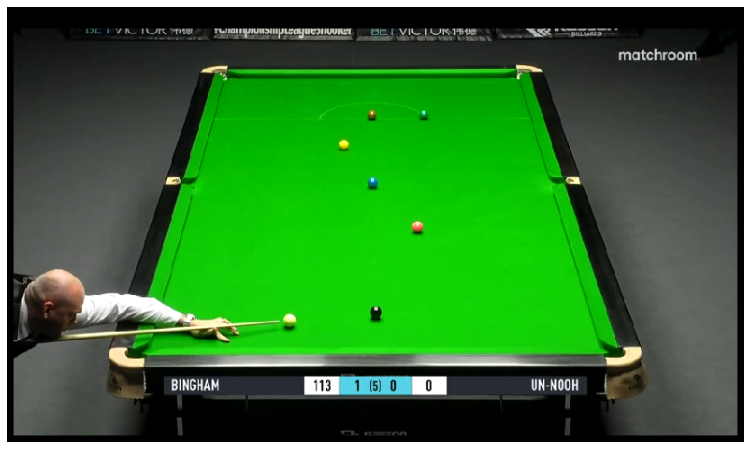

In [34]:
image_path = '/Users/frank_fan/Desktop/School/2024_spring/Computer_vision/Final_proj/test_image.png' # customize as needed
image = cv2.imread(image_path)

if image is not None:
    # convert the image from BGR to RGB
    frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize = (16, 8))
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
else:
    print("Error: Image not found or unable to read.")

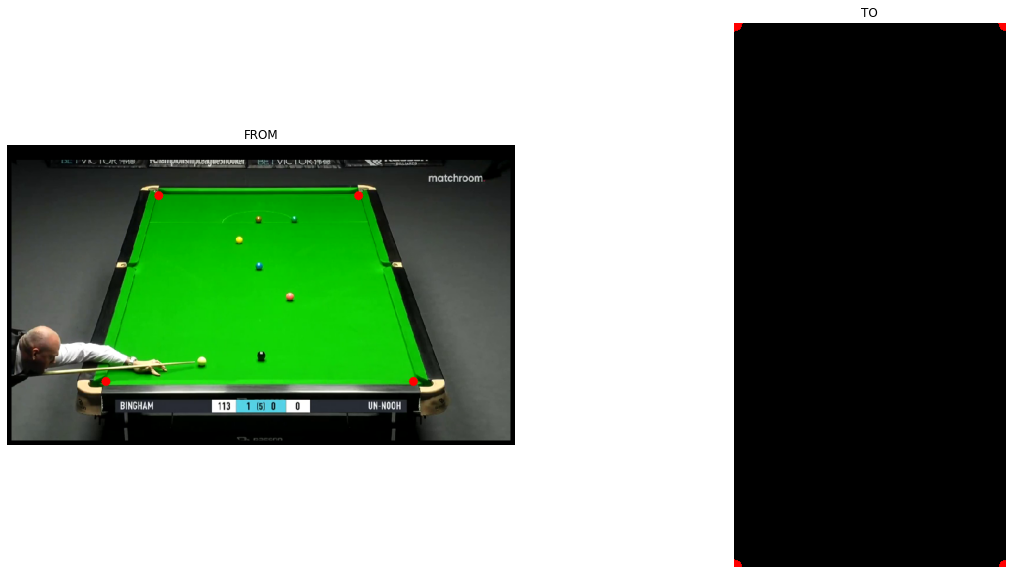

In [35]:
# visualization:

# red points on corners of original table
table = frame.copy() # add points to pool table corners
cv2.circle(table, (153, 366), 7, 255, -1) # bot left
cv2.circle(table, (630, 366), 7, 255, -1) # bot right
cv2.circle(table, (235, 78), 7, 255, -1)  # top left
cv2.circle(table, (545, 78), 7, 255, -1)  # top right

# red points on corners of generated table
img = np.zeros((height,width,3), dtype=np.uint8)
new_img = img.copy() # add points to edges of img
cv2.circle(new_img, (0, 0), 8, 255, -1)          # bot left
cv2.circle(new_img, (width, 0), 8, 255, -1)      # bot right
cv2.circle(new_img, (0, height), 8, 255, -1)     # top left
cv2.circle(new_img, (width, height), 8, 255, -1) # top right

plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.imshow(table)
plt.title('FROM')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(new_img)
plt.title('TO')
plt.axis('off')
plt.show()

using points of both images we can get the perspective

In [36]:
# creating points of original data and new generated img
pts1 = np.float32([ [235, 78],[545, 78],[153, 366],[630, 366] ])     # 4 corners points of ORIGINAL image
pts2 = np.float32([ [0, 0],[width, 0],[0, height],[width, height] ]) # 4 corners points of OUTPUT image

matrix = cv2.getPerspectiveTransform(pts1, pts2) # getting perspective by 4 points of each image
transformed = cv2.warpPerspective(frame, matrix, (width, height)) # warps perpective to new image


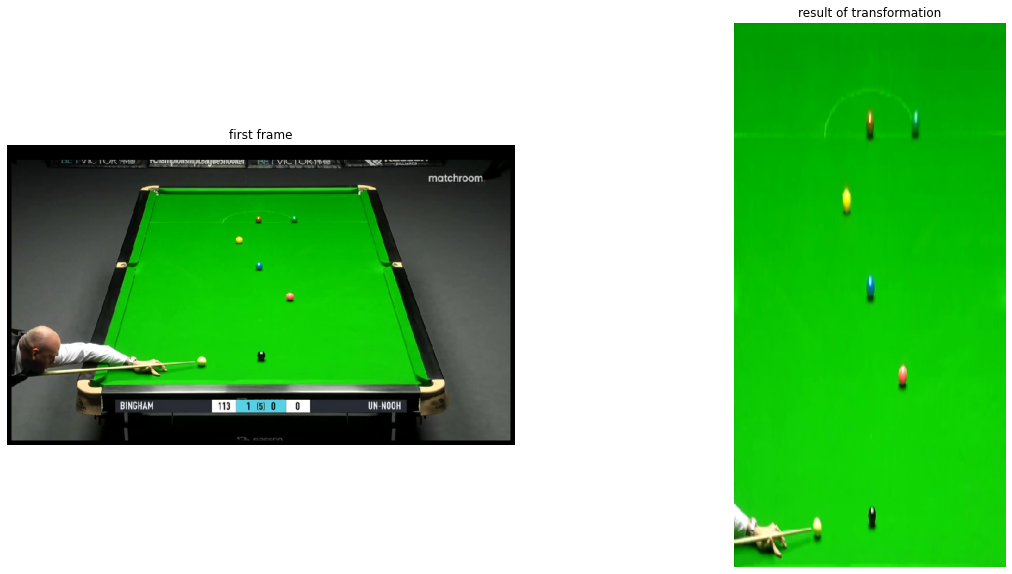

In [37]:
plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.title('first frame')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed)
plt.title('result of transformation')
plt.axis('off')
plt.show()


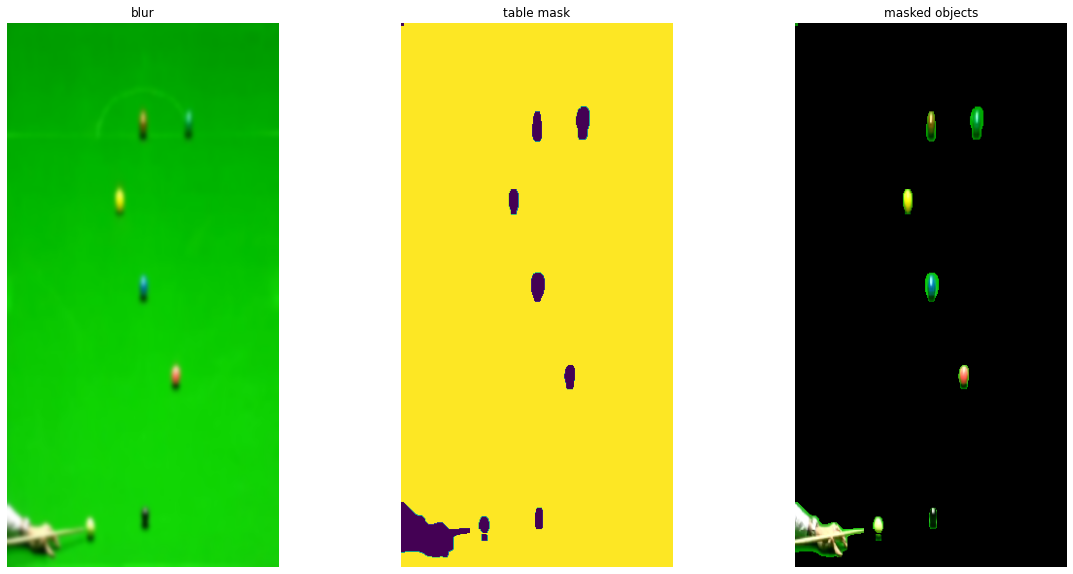

In [38]:
transformed_blur = cv2.GaussianBlur(transformed,(0, 0), 2) # blur applied
blur_RGB = cv2.cvtColor(transformed_blur, cv2.COLOR_BGR2RGB) # rgb version

# hsv colors of the snooker table
lower = np.array([60, 200, 150]) 
upper = np.array([70, 255, 240]) # HSV of snooker green: (60-70, 200-255, 150-240) 

hsv = cv2.cvtColor(blur_RGB, cv2.COLOR_RGB2HSV) # convert to hsv
mask = cv2.inRange(hsv, lower, upper)           # table's mask

# apply closing
kernel = np.ones((5, 5), np.uint8)
mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)          # dilate -> erode

# invert mask to focus on objects on table
_,mask_inv = cv2.threshold(mask_closing, 5, 255, cv2.THRESH_BINARY_INV) # mask inv

masked_img = cv2.bitwise_and(transformed, transformed, mask = mask_inv) # masked image with inverted mask

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(transformed_blur)
plt.title('blur')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_closing)
plt.title('table mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(masked_img) 
plt.title('masked objects')
plt.axis('off')
plt.show()

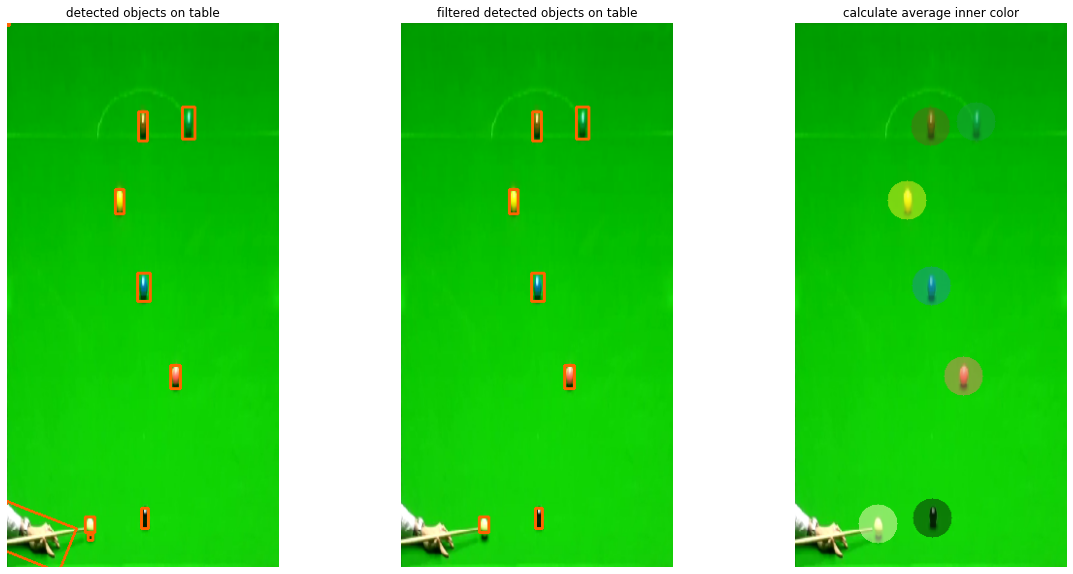

In [39]:
# find contours and filter them
ctrs, hierarchy = cv2.findContours(mask_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # create contours in filtered img

# draw contours before filter
detected_objects = draw_rectangles(ctrs, transformed) # detected objects will be marked in boxes

ctrs_filtered = filter_ctrs(ctrs) # filter unwanted contours (wrong size or shape)

# draw contours after filter
detected_objects_filtered = draw_rectangles(ctrs_filtered, transformed) # filtered detected objects will be marked in boxes

# find average color inside contours:
ctrs_color = find_ctrs_color(ctrs_filtered, transformed)
ctrs_color = cv2.addWeighted(ctrs_color, 0.5, transformed, 0.5, 0) # contours color image + transformed image

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(detected_objects)
plt.title('detected objects on table')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(detected_objects_filtered)
plt.title('filtered detected objects on table')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(ctrs_color)
plt.title('calculate average inner color')
plt.axis('off')
plt.show()

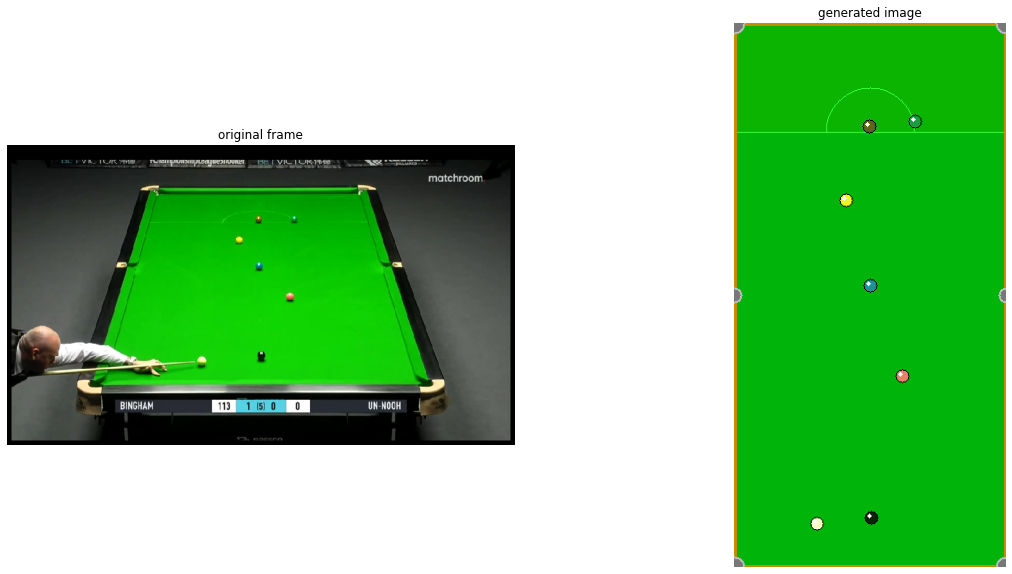

In [40]:
# design of the 2D generated table
final = draw_balls(ctrs_filtered, img = transformed) # gets contours and draws balls in their centers
final = draw_holes(final) # draws holes in the 2D img

plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.title('original frame')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final)
plt.title('generated image')
plt.axis('off')
plt.show()